In [1]:
import os
from dotenv import load_dotenv
import numpy as np
import pandas as pd
from binance.client import Client

load_dotenv()  # loads .env from current working directory

api_key = os.getenv("BINANCE_US_KEY")
api_secret = os.getenv("BINANCE_US_SECRET")

### Time columns (Unix epoch in milliseconds)

**`open_time`**

* The **start timestamp** of the candle (the moment this bar begins).
* Stored as **Unix time in milliseconds** (ms since 1970-01-01 UTC).

**`close_time`**

* The **end timestamp** of the candle (when the bar ends).
* Also **Unix ms**.

> Practical note: In many Binance exports, `close_time` is the **end of the interval** (often the last millisecond of the candle). The exact convention isn’t important as long as you consistently convert and sort by `open_time`.
---

### Price columns (in quote currency per 1 base unit)

All are prices in **USDT per BTC** for BTCUSDT:

**`open`**

* Price at the **start** of the candle.

**`high`**

* Highest price traded **during** the candle.

**`low`**

* Lowest price traded **during** the candle.

**`close`**

* Price at the **end** of the candle.

---

### Volume + activity columns

**`volume`** *(Base asset volume)*

* Total amount of **BTC traded** during the candle.
* In your row: `21.77684` BTC traded in that interval.

**`quote_volume`** *(Quote asset volume)*

* Total traded value in **USDT** during the candle.
* Roughly: (\sum (\text{price} \times \text{BTC amount})) across all trades.
* In your row: `1,882,957.35` USDT worth of BTC traded.

**`count`**

* Number of individual trades that occurred during the candle.
* In your row: `2394` trades.

---

### “Taker buy” columns (aggressor-side volume)

“Taker” = the side that **removes liquidity** (market orders / aggressive limit orders that instantly fill).

**`taker_buy_base_volume`**

* Total amount of **BTC bought by takers** during the candle.
* Think: “how much BTC was bought via aggressive buy orders.”

**`taker_buy_quote_volume`**

* Same concept, but in **USDT**.
* In your row: `809,719.55` USDT of taker-driven buying.

> Quick intuition: If `taker_buy_*` is a large fraction of total volume, buying pressure was relatively aggressive during that candle.

---

Best practice:

* Read `open_time` / `close_time` as **integers** (no decimals).
* Convert with: `pd.to_datetime(col, unit="ms", utc=True)` in pandas.


## Exploring Data

Yes — it’s not just “okay,” it’s the **right way to think** as long as you’re clear what each timeframe is telling you.

### Why 1D plots are still useful even if you trade on 1H

Your 1D volatility + drawdown plots are basically **regime diagnostics**:

* Are we in a deep drawdown environment?
* Are we in a high-volatility “storm” period?
* Is the market trending or chopping?

Those are *slow-moving* properties. Even if your bot executes hourly, it benefits from a **daily-level “climate map”** to avoid doing dumb things during bad regimes.

So: use **1D for understanding + regime filters**, and **1H for execution + stop behavior**.

### What you should NOT do

Don’t tune your 1H trading parameters purely from 1D plots. Examples:

* ATR(14) on 1D ≠ ATR(14) on 1H
* rolling vol on 1D ≠ rolling vol on 1H
* stop-loss distances and whipsaw rates will be totally different

### The clean workflow for your project

1. Keep **1H as your base dataset** (2022→now).
2. **Resample 1H → 1D** to compute:

   * drawdowns
   * long-term volatility regimes
   * SMA200 regime filter
3. Use **1H** to compute:

   * execution ATR (hourly ATR)
   * entries/exits
   * intraday risk controls

### A simple “multi-timeframe” rule that fits your hybrid strategy

* **Daily regime filter** decides whether you’re allowed to be aggressive:

  * Risk-on: allow swing trades, normal DCA
  * Risk-off: reduce size, widen stops, or pause tactical trades
* **Hourly logic** decides *exactly when* to act and where stops sit.

### Sanity check you can do

Make the same plots on 1H (properly annualized) and compare regimes. You’ll see:

* 1H vol is noisier and spikes more often
* 1D vol is smoother and better for “regime” labeling

So: your 1D plots are the “macro lens,” and your 1H dataset is the “micro lens.” A good agent uses both lenses without mixing up their prescriptions.


In [ ]:
import os
import time
from datetime import datetime, timezone, timedelta
from pathlib import Path

import numpy as np
import pandas as pd
import ccxt
from dotenv import load_dotenv


def fetch_binanceus_ohlcv_last_couple_y_and_save(
    symbol: str = "BTC/USDT",
    timeframe: str = "1d",
    years_back: int = 4,
    out_dir: str | Path = ".",
    base_filename: str | None = None,
    limit: int = 1000,
) -> pd.DataFrame:
    """
    Fetch OHLCV from Binance.US via CCXT using pagination (since -> now),
    then save to Parquet + CSV and return the DataFrame.

    Notes:
    - CCXT OHLCV rows are: [timestamp_ms, open, high, low, close, volume]
    - Binance.US supports public OHLCV without auth, but keys are fine to include.
    """

    load_dotenv()

    api_key = os.getenv("BINANCE_US_KEY")
    api_secret = os.getenv("BINANCE_US_SECRET")

    exchange = ccxt.binanceus(
        {
            "apiKey": api_key,
            "secret": api_secret,
            "enableRateLimit": True,  # CCXT will pace requests
            # "options": {"adjustForTimeDifference": True},  # optional
        }
    )

    # Optional: sanity check that exchange is reachable
    exchange.load_markets()
    # Prepare output directory
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    if base_filename is None:
        base_filename = f"{symbol.replace('/', '')}_{timeframe}_{years_back}y_to_now"

    # 4 years ago, but anchored to Jan 1 of that year (UTC)
    now = datetime.now(timezone.utc)
    start_dt = datetime(now.year - 4, 1, 1, tzinfo=timezone.utc)
    since_ms = int(start_dt.timestamp() * 1000)
    # current time in ms
    now_ms = exchange.milliseconds()
    # candle length in milliseconds, 
    tf_ms = int(exchange.parse_timeframe(timeframe) * 1000)

    all_rows: list[list[float]] = []    # accumlates all candles
    last_ts = None  # tracks last timestamp to detect no-progress
    # Pagination loop, fetching batches until we reach "now"
    while since_ms < now_ms:
        batch = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=since_ms, limit=limit)

        if not batch:
            break

        # Guard against infinite loops if exchange returns same last candle repeatedly
        # the open timestamp of the last candle in this batch
        batch_last_ts = batch[-1][0]
        if last_ts is not None and batch_last_ts <= last_ts:
            break
        # accumulate results
        all_rows.extend(batch)
        last_ts = batch_last_ts

        # move "since" to just after the last candle to avoid duplicates
        # Next request, start at the next candle after the last one I already have.
        since_ms = batch_last_ts + tf_ms

        # If you want extra politeness even with enableRateLimit:
        time.sleep(exchange.rateLimit / 1000)

    if not all_rows:
        raise RuntimeError(f"No OHLCV data returned for {symbol} {timeframe} on Binance.US.")

    df = pd.DataFrame(all_rows, columns=["Date", "open", "high", "low", "close", "volume"])

    # Convert timestamp and clean types
    df["Date"] = pd.to_datetime(df["Date"], unit="ms", utc=True)
    for c in ["open", "high", "low", "close", "volume"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # Clean duplicates + sort + index (pagination can overlap depending on exchange quirks)
    df = (
        df.dropna(subset=["Date", "open", "high", "low", "close", "volume"])
          .drop_duplicates(subset=["Date"])
          .sort_values("Date")
          .set_index("Date")
    )

    # Keep only what you need + add log returns
    df = df[["open", "high", "low", "close", "volume"]].copy()
    # Add log return column, log(close_t) - log(close_{t-1})
    df["log_ret"] = np.log(df["close"]).diff()

    # Save to Parquet + CSV
    parquet_path = out_dir / f"{base_filename}.parquet"
    csv_path = out_dir / f"{base_filename}.csv"

    # Parquet requires an engine (pyarrow or fastparquet). CSV always works.
    try:
        df.to_parquet(parquet_path, index=True)
    except Exception as e:
        print(
            f"[WARN] Parquet save failed ({type(e).__name__}: {e}). "
            "Install 'pyarrow' (recommended) or 'fastparquet' to enable Parquet."
        )

    df.to_csv(csv_path, index=True)

    return df





In [ ]:

# Example usage:
df_1d = fetch_binanceus_ohlcv_last_couple_y_and_save(
     symbol="BTC/USDT",
     timeframe="1d",
     years_back=4,
     out_dir="Data",
)
df_1h = fetch_binanceus_ohlcv_last_couple_y_and_save(
     symbol="BTC/USDT",
     timeframe="1h",
     years_back=4,
     out_dir="Data",
)


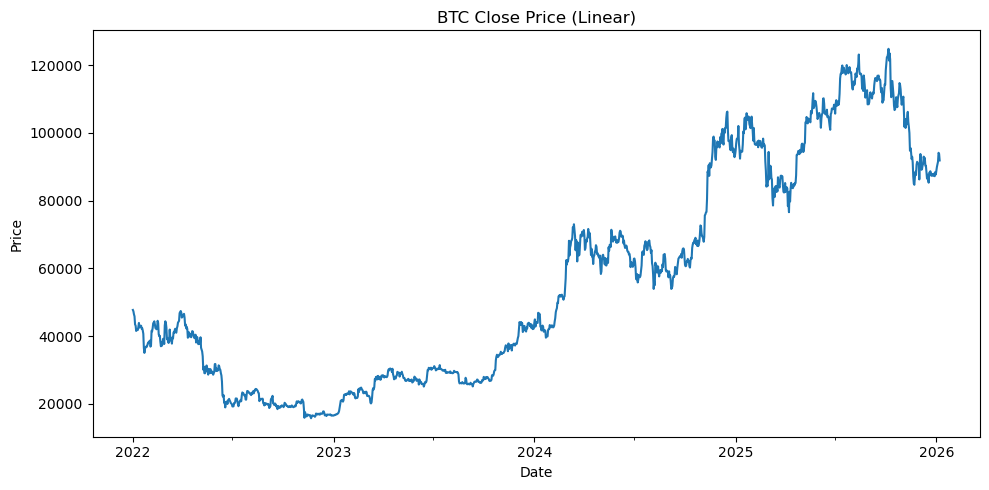

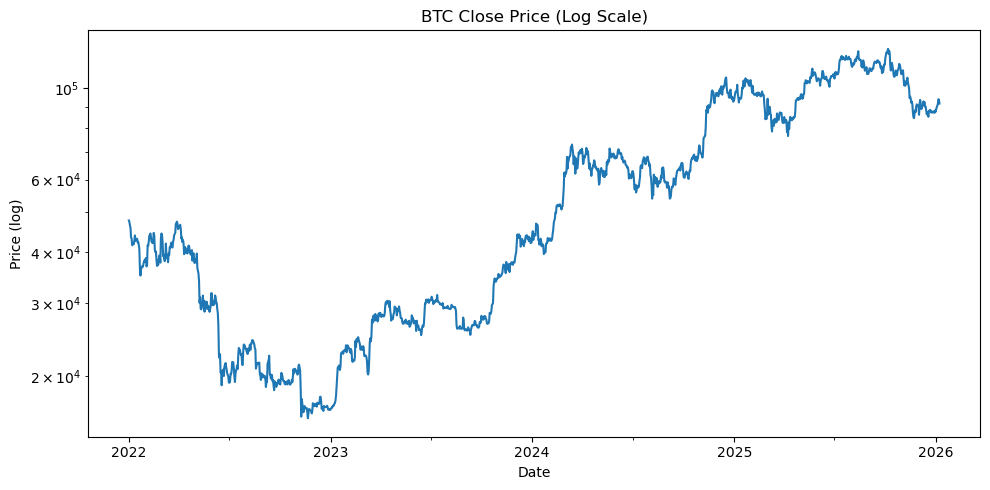

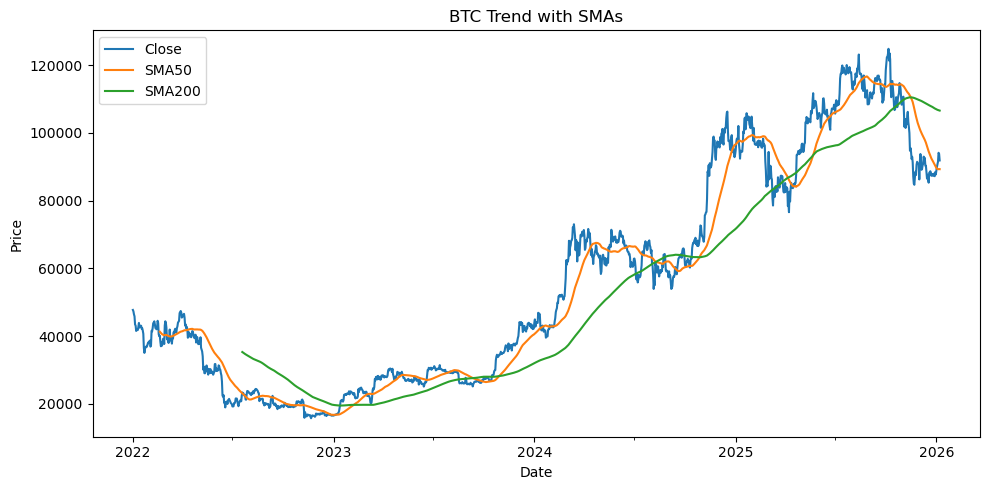

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


def plot_btc_trend_and_smas(
    df,
    price_col: str = "close",
    sma_windows=(50, 200),
    figsize=(10, 5),
    add_sma_cols: bool = True,
    year_ticks: bool = True,
):
    """
    Plots:
      1) Price (linear)
      2) Price (log scale)
      3) Price + SMAs

    Args:
      df: DataFrame indexed by datetime (e.g., df.index is a DatetimeIndex)
      price_col: column name for price series (default: 'close')
      sma_windows: tuple/list of SMA window sizes (default: (50, 200))
      figsize: matplotlib figure size
      add_sma_cols: if True, adds SMA columns into df (e.g., 'sma50', 'sma200')
      year_ticks: if True, formats x-axis with yearly ticks
    """

    def format_xaxis_years(ax):
        ax.xaxis.set_major_locator(mdates.YearLocator())               # every year
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))       # show only year
        ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(1, 7)))  # optional
        plt.setp(ax.get_xticklabels(), rotation=0, ha="center")

    # Basic checks (lightweight)
    if price_col not in df.columns:
        raise KeyError(f"'{price_col}' not found in df.columns.")
    if not hasattr(df.index, "to_pydatetime"):
        raise TypeError("df.index must be datetime-like (e.g., a DatetimeIndex).")

    # --- 1) Linear ---
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(df.index, df[price_col])
    ax.set_title("BTC Close Price (Linear)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    if year_ticks:
        format_xaxis_years(ax)
    plt.tight_layout()
    plt.show()

    # --- 2) Log scale ---
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(df.index, df[price_col])
    ax.set_yscale("log") # set y-axis to log scale
    ax.set_title("BTC Close Price (Log Scale)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Price (log)")
    if year_ticks:
        format_xaxis_years(ax)
    plt.tight_layout()
    plt.show()

    # --- 3) Moving averages ---
    sma_cols = []
    for w in sma_windows:
        col = f"sma{int(w)}"
        sma_cols.append(col)
        if add_sma_cols:
            df[col] = df[price_col].rolling(int(w)).mean()
        else:
            # compute without mutating df
            df = df.copy()
            df[col] = df[price_col].rolling(int(w)).mean()

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(df.index, df[price_col], label="Close")
    for col in sma_cols:
        ax.plot(df.index, df[col], label=col.upper())
    ax.set_title("BTC Trend with SMAs")
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.legend()
    if year_ticks:
        format_xaxis_years(ax)
    plt.tight_layout()
    plt.show()

    return df  # includes SMA columns if add_sma_cols=True


# usage:
df = plot_btc_trend_and_smas(df_1d, price_col="close", sma_windows=(50, 200))


You can squeeze a lot of “regime intelligence” out of these three plots—especially for a **DCA + ATR stop + regime filter** agent.

## 1) Linear price plot: “absolute moves + pain scale”

What it tells you best:

* **Regime sequence is obvious**: a deep drawdown/sideways base in 2022–2023, a strong uptrend through 2024–mid 2025, then a meaningful pullback into late 2025/early 2026.
* **Volatility clusters**: the really choppy periods tend to bunch up (big swings around trend inflection points). This is exactly where ATR-based stops can get whipsawed if they’re too tight.
* **Drawdowns matter in dollars**: late-cycle moves are huge in $ terms (e.g., falling from 120k → 90k is “only” -25% but it’s a gigantic absolute move). That’s why looking only at linear can trick your intuition.

## 2) Log-scale price plot: “percentage moves + growth regimes”

This is the one traders love because it makes **relative returns** comparable across time.

* **You can compare % moves fairly**: a move from 20k→40k looks the same “steepness” as 60k→120k (both ~2×), which is what your returns actually care about.
* **Trend changes are clearer**: you can visually see when BTC transitions from downtrend → flat/accumulation → sustained uptrend.
* **It hints at where DCA shines**: the long flat/base period (2022–2023) is where systematic accumulation tends to look smartest in hindsight, because it’s buying during low-growth/low-hype phases.

## 3) SMA plot (Close + SMA50 + SMA200): “trend filter + regime labeling”

This is your “are we in risk-on or risk-off?” dashboard.

* **SMA200 (green) = long-term regime**

  * When price is **above SMA200** and SMA200 is rising, you’re generally in **bull-ish / risk-on** conditions.
  * When price is **below SMA200** and SMA200 is falling/flat, conditions are **risk-off** and many long-only strategies bleed or chop.

* **SMA50 (orange) = medium-term momentum**

  * When SMA50 is above SMA200, that’s a classic “trend is healthy” signal.
  * When SMA50 rolls over and crosses below SMA200 (or threatens to), that’s a warning that the medium-term trend is deteriorating.

* **Crossovers (useful, but don’t worship them)**

  * A “golden cross” (SMA50 > SMA200) tends to happen **after** the move has already started.
  * A “death cross” tends to happen **after** damage is already done.
  * These are lagging signals—great as **regime filters**, not as precision entry/exit tools.

## What this means for your project

* **DCA base layer**: These plots suggest BTC has long multi-month regimes. DCA benefits from those long horizons, especially during basing/accumulation phases.
* **ATR stops**: ATR will expand during the choppy transition zones you can see around major trend shifts. If your ATR stop is too tight, you’ll get shaken out repeatedly.
* **Strategy switching**: SMA200 slope/price relationship can be a clean, explainable “mode switch”:

  * Risk-on: allow tactical swing trades + larger exposure
  * Risk-off: reduce tactical trading, slow DCA, tighten risk caps, or go more flat

## One caution (the universe’s way of keeping us humble)

SMA-based conclusions depend heavily on your window lengths (50/200) and your timeframe (daily vs hourly). They’re great for *labeling regimes*, but they’re not a guarantee of future performance—just a structured way to avoid trading purely on vibes.

If you want, I can show you how to turn what you’re seeing here into an explicit regime variable like `regime = "risk_on" | "risk_off"` and plug it into your bot’s decision rules (DCA aggressiveness, whether to allow swing entries, ATR multiplier changes).


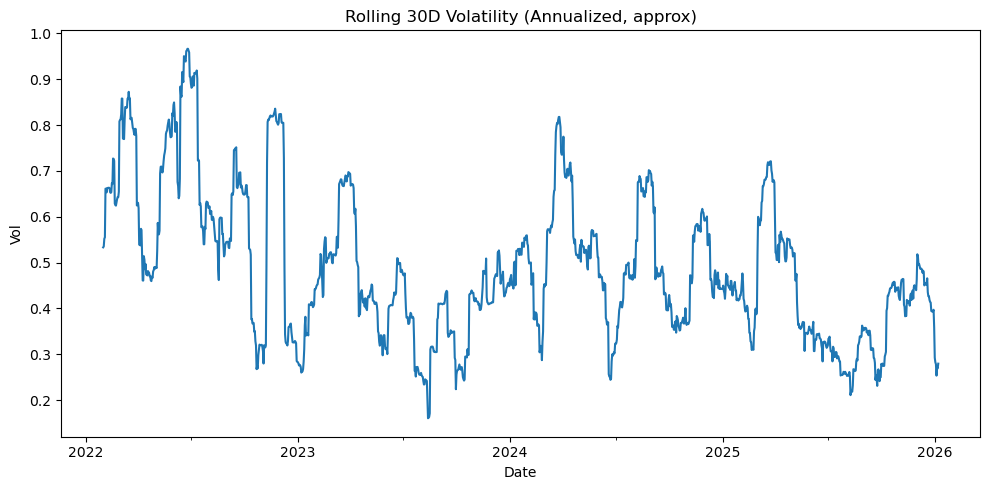

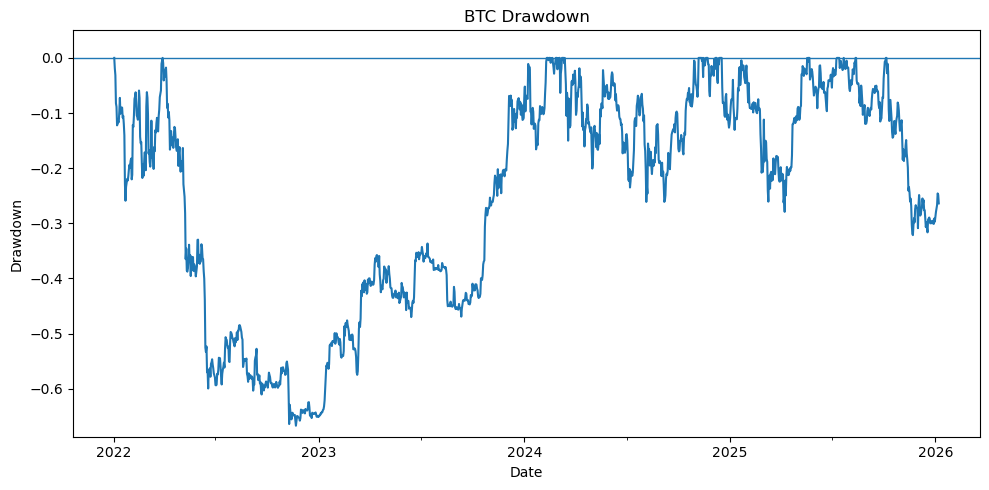

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np


def plot_volatility_and_drawdown(
    df,
    log_ret_col: str = "log_ret",
    vol_window: int = 30,
    annualization_factor: int = 365,
    add_vol_col: bool = True,
    vol_col_name: str | None = None,
    figsize=(10, 5),
    year_ticks: bool = True,
):
    """
    Plots:
      1) Rolling volatility (annualized)
      2) Drawdown curve

    Args:
      df: DataFrame indexed by datetime
      log_ret_col: column name for log returns (default: 'log_ret')
      vol_window: rolling window length in periods (default: 30)
      annualization_factor: annualization factor for volatility (365 for crypto daily, 252 for equities)
      add_vol_col: if True, writes rolling vol column into df
      vol_col_name: optional custom name for vol column; default "vol_{vol_window}d"
      figsize: matplotlib figure size
      year_ticks: whether to format x-axis with yearly ticks

    Returns:
      df_out: DataFrame (includes volatility column if add_vol_col=True)
      dd: drawdown Series
    """

    def format_xaxis_years(ax):
        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
        ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(1, 7)))
        plt.setp(ax.get_xticklabels(), rotation=0, ha="center")
    # Basic checks (lightweight)
    if log_ret_col not in df.columns:
        raise KeyError(f"'{log_ret_col}' not found in df.columns.")
    if not hasattr(df.index, "to_pydatetime"):
        raise TypeError("df.index must be datetime-like (e.g., a DatetimeIndex).")
    # modify df or copy
    df_out = df if add_vol_col else df.copy()

    # --- Rolling volatility (annualized) ---
    if vol_col_name is None:
        vol_col_name = f"vol_{vol_window}d"

    df_out[vol_col_name] = (
        df_out[log_ret_col].rolling(vol_window).std() * np.sqrt(annualization_factor)
    )

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(df_out.index, df_out[vol_col_name])
    ax.set_title(f"Rolling {vol_window}D Volatility (Annualized, approx)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Vol")
    if year_ticks:
        format_xaxis_years(ax)
    plt.tight_layout()
    plt.show()

    # --- Drawdown curve ---
    # normalized equity curve from 1.0 using log returns
    cum = df_out[log_ret_col].cumsum().apply(np.exp)
    peak = cum.cummax()
    dd = (cum / peak) - 1.0

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(df_out.index, dd)
    ax.set_title("BTC Drawdown")
    ax.set_xlabel("Date")
    ax.set_ylabel("Drawdown")

    # headroom so 0 line isn't visually clipped
    min_dd = float(dd.min())
    ax.set_ylim(min_dd - 0.02, 0.05)
    ax.axhline(0, linewidth=1)

    if year_ticks:
        format_xaxis_years(ax)
    plt.tight_layout()
    plt.show()

    return df_out, dd


# usage:
df, dd = plot_volatility_and_drawdown(df, log_ret_col="log_ret", vol_window=30, annualization_factor=365)


These two plots are basically your bot’s “weather report”: **how stormy the market is (volatility)** and **how deep the ocean trenches are (drawdowns)**. For a DCA + ATR + risk-off agent, they’re gold.

## 1) Rolling 30D Volatility (annualized)

What it’s saying:

* **BTC is often extremely volatile** — your 30D annualized vol spends a lot of time around ~0.3–0.6 (30%–60%) and spikes up toward ~0.8–1.0 (80%–100%) early in the window. That’s not “stocks volatile,” that’s “hold my energy drink” volatile.
* **Volatility is regime-like (clusters)**:

  * **High-vol regime in 2022** (lots of spikes): this is typical of bear markets / deleveraging phases.
  * **Moderate, choppy volatility in 2023–2024**: still active, but not the same panic intensity.
  * **Lower volatility pockets in parts of 2025** (down near ~0.25–0.35), followed by re-acceleration later.

**Implication for your agent**

* ATR-based stops must be **adaptive** because the “normal” volatility level changes a lot.
* If you use a fixed stop distance or fixed DCA trigger percentage, it will behave very differently depending on whether vol is 0.25 or 0.90.
* A smart tweak is to make DCA aggressiveness / position size *vol-aware* (less aggressive when vol is very high).

## 2) BTC Drawdown

Drawdown is “how far below the last all-time-high you currently are” (0 = at peak).

What it’s saying:

* **2022–early 2023 shows a brutal max drawdown ~-65%** (roughly). That’s the kind of event your portfolio-level safeguard is meant to survive.
* **2024–mid 2025 is mostly shallow drawdowns** (often between 0 and -20%): this is a relatively strong uptrend regime where buy-and-hold looks great.
* **late 2025 → early 2026 drawdown deepens again (~-30%)**: a reminder that even during “good years,” BTC can slap you with sudden large declines.

**Implication for your agent**

* If your system’s *global safeguard* is something like “pause at -25%,” it would have:

  * triggered hard during 2022 (and maybe prevented catastrophic compounding losses),
  * probably stayed off during much of 2024–2025,
  * and might trigger again in late 2025.
* A big drawdown period is where pure DCA can look psychologically and financially dangerous unless you cap exposure or change behavior (e.g., slow DCA, reduce size, or require trend confirmation).

## The combined story (the useful part)

* **High volatility tends to coincide with deep drawdowns** (especially 2022). That’s when your strategy needs to be conservative, because noise + downtrend = stop-loss whipsaw and “buying dips that keep dipping.”
* **When volatility settles and drawdowns stay shallow**, trend-following overlays and DCA generally behave better (2024–2025).

## Practical takeaways for your design

* Use these plots to justify **regime logic**:

  * **Risk-on:** price above SMA200 and vol not exploding → allow swing trades + normal DCA
  * **Risk-off:** deep drawdown or vol spike → reduce size, widen ATR multiple, or pause tactical trades
* Treat the 2022 segment as your **stress test**: if the bot survives that without blowing up, it’s closer to “real.”

If you want, I can show you how to compute and print the two key numbers that summarize these plots for your report: **max drawdown** and **percent of time volatility is above a chosen threshold** (e.g., vol_30d > 0.6).


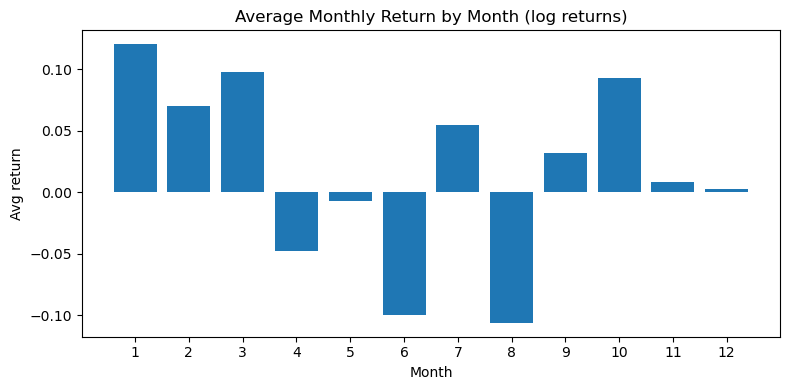

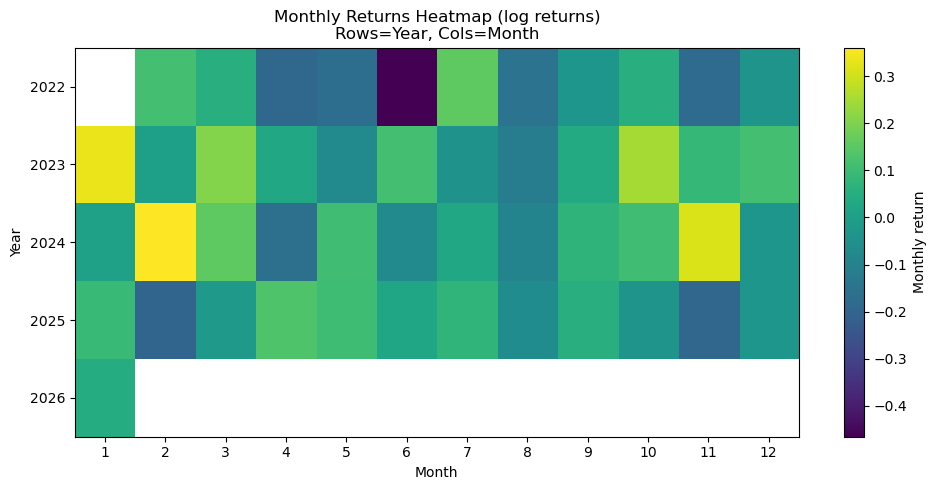

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def plot_monthly_seasonality_with_heatmap_table(
    df: pd.DataFrame,
    price_col: str = "close",
    use_log_returns: bool = True,
    resample_rule: str = "ME",          # month-end
    bar_figsize=(8, 4),
    heatmap_figsize=(10, 5),
    show_bar: bool = True,
    show_heatmap: bool = True,
):
    """
    Seasonality by month:
      - Average monthly return by month (bar)
      - Heatmap table (Year x Month returns) rendered via plt.imshow()

    Includes the explicit "Year × Month returns" table construction you provided.

    Args:
      df: DataFrame with DatetimeIndex
      price_col: column to use for price (default: 'close')
      use_log_returns: True -> log returns, False -> simple returns
      resample_rule: 'ME' (month end) recommended
      bar_figsize: figure size for bar chart
      heatmap_figsize: figure size for heatmap
      show_bar: whether to show bar chart
      show_heatmap: whether to show heatmap

    Returns:
      month_of_year: Series indexed by month (1..12) average monthly return
      table: DataFrame indexed by year, columns=month (1..12) monthly returns
      monthly_ret: Series of monthly returns (DatetimeIndex at month-end)
    """
    if price_col not in df.columns:
        raise KeyError(f"'{price_col}' not found in df.columns.")
    if not isinstance(df.index, pd.DatetimeIndex):
        raise TypeError("df.index must be a pandas DatetimeIndex.")

    # Monthly close (end-of-month close)
    monthly_close = df[price_col].resample(resample_rule).last()

    # Monthly returns
    if use_log_returns:
        monthly_ret = np.log(monthly_close).diff()
        ret_label = "log returns"
    else:
        monthly_ret = monthly_close.pct_change()
        ret_label = "simple returns"

    # --- 3) Average monthly returns by month ---
    month_of_year = monthly_ret.groupby(monthly_ret.index.month).mean()

    if show_bar:
        plt.figure(figsize=bar_figsize)
        plt.bar(range(1, 13), [month_of_year.get(m, np.nan) for m in range(1, 13)])
        plt.title(f"Average Monthly Return by Month ({ret_label})")
        plt.xlabel("Month")
        plt.ylabel("Avg return")
        plt.xticks(range(1, 13))
        plt.tight_layout()
        plt.show()

    # --- 4) Seasonality heatmap-style table (Year × Month returns) ---
    # This block is the same logic as your snippet, generalized for log/simple returns.
    mret = monthly_ret.copy()
    table = (
        mret.to_frame("ret")
        .assign(year=mret.index.year, month=mret.index.month)
        .pivot(index="year", columns="month", values="ret")
        .sort_index()
    )

    if show_heatmap:
        plt.figure(figsize=heatmap_figsize)
        plt.imshow(table.values, aspect="auto")
        plt.title(f"Monthly Returns Heatmap ({ret_label})\nRows=Year, Cols=Month")
        plt.xlabel("Month")
        plt.ylabel("Year")
        plt.xticks(range(12), range(1, 13))
        plt.yticks(range(len(table.index)), table.index)
        plt.colorbar(label="Monthly return")
        plt.tight_layout()
        plt.show()

    


# Example usage:
plot_monthly_seasonality_with_heatmap_table(df, price_col="close", use_log_returns=True)


Nice — this updated version tells a similar story, just a bit “cleaner” and more balanced.

### What it says (in plain English)

Using your dataset window, the **average monthly return depends on the month**, with a few months standing out:

**Stronger months (positive average):**

* **January (1)** is the strongest in your sample (big positive bar).
* **March (3)** and **October (10)** are also clearly positive.
* **February (2)**, **July (7)**, **September (9)** are mildly-to-moderately positive.
* **Nov/Dec (11/12)** look basically flat to slightly positive.

**Weaker months (negative average):**

* **June (6)** and **August (8)** are the worst (most negative).
* **April (4)** is also negative.
* **May (5)** is slightly negative (near zero but below).

### The important interpretation for your project

This suggests a *possible* seasonal pattern:

* **Early year (Jan–Mar) stronger**
* **Mid-year (Apr–Aug) weaker / choppier**
* **Fall (Sep–Oct) stronger again**

But—and this matters—BTC seasonality is often **fragile**:

* Your sample is only a handful of years, so a couple giant months can dominate the mean.
* Crypto regimes (bull/bear) can override “month effects.”

### How to use this responsibly (without fooling yourself)

Use it as:

* **A diagnostic / hypothesis**, not a trading rule.
* A reason to test: “Does this hold over a longer window (e.g., 2016–now) and in walk-forward splits?”

If it *does* hold robustly, you might use it as a **soft modifier**, like:

* reduce DCA aggressiveness slightly in months that tend to be weak (Jun/Aug),
* or require stronger confirmation for swing entries during those months.

### Quick next step (high value)

Add uncertainty:

* Plot **median** monthly returns (less outlier-sensitive)
* Add **error bars** (standard error / bootstrap CI) so you can see which months are actually distinguishable from noise

Right now the plot says: **Jan/Mar/Oct look strong; Jun/Aug look weak** in your sample. The next question is whether that’s signal or just “your particular slice of Bitcoin history.”


This heatmap is the “truth serum” for your monthly seasonality bar chart. The bar chart shows **average** month effects; this heatmap shows **whether those effects are consistent year-to-year** or just driven by a couple standout months.

### How to read it

* **Rows = years**, **columns = months**
* **Yellow/green = positive monthly return**, **blue/purple = negative**
* The colorbar shows magnitude (bigger positive vs bigger negative).

### What your heatmap is saying

1. **Monthly returns are not consistently the same color across years.**
   Example: a month that’s green one year may be blue the next. That means “seasonality” is **weak/unstable** in this sample.

2. **There are a few repeated “tendencies,” but they’re not iron laws.**

   * **June (6)** shows a notably bad month in **2022** (deep purple) and is not reliably strong elsewhere → this supports your earlier “June weakness” impression.
   * **October (10)** and **January (1)** look more often positive than negative in your sample, but not perfectly consistent.

3. **Regime dominates calendar.**
   The pattern looks more like:

   * **2022** has more negative months (bear-market vibes),
   * **2023–2024** skew greener (recovery/bull),
   * **2025** is mixed,
     than like a repeating seasonal cycle.
     That’s a classic crypto feature: **market regime > month-of-year**.

4. **Your dataset window is short, so be cautious.**
   You have only a few full years (2022–2025, plus a partial 2026 row). With ~3–4 samples per month, averages can be pushed around easily.

### What this means for your trading agent

* You **should not** hard-code “buy more in October” or “reduce risk in June” based on this alone.
* If you want to use seasonality at all, it should be a **soft feature** (tiny weight) and it must be validated on a longer history and with walk-forward testing.
* The more robust takeaway is: build **regime-aware logic** (trend/vol/drawdown filters), because that’s what’s clearly driving outcomes in your sample.

### One quick improvement (high value)

Add a plot that counts consistency:

* For each month, compute “% of years positive” (e.g., Jan positive in 3/4 years = 75%).
  That will quantify whether any month is actually dependable.

Bottom line: the heatmap suggests **some hints of seasonality**, but it mostly screams: **BTC’s month-to-month behavior is dominated by broader market regimes, not the calendar.**


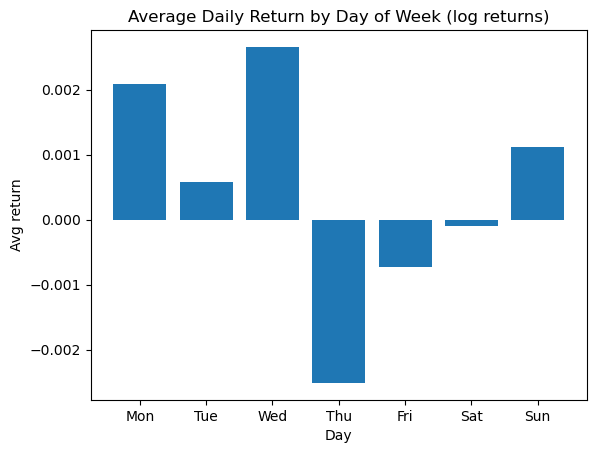

In [10]:
# 5) Day-of-week effect (often small, but easy to check)
dow = df["log_ret"].groupby(df.index.dayofweek).mean()  # 0=Mon ... 6=Sun
labels = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]

plt.figure()
plt.bar(labels, dow.values)
plt.title("Average Daily Return by Day of Week (log returns)")
plt.xlabel("Day"); plt.ylabel("Avg return")
plt.show()


This plot is answering: **“In your sample, are average BTC daily returns different depending on the day of the week?”**

### What it says in your dataset

* **Mon/Wed are positive on average**, with **Wednesday the strongest**.
* **Thursday is the most negative** (clearly the weakest day in your sample).
* **Friday is mildly negative**.
* **Saturday is basically flat** (near zero).
* **Sunday is mildly positive**.

So, in this window, returns look **front-loaded early in the week**, dip mid/late week (especially Thu), and recover a bit by Sunday.

### The important caveat (so you don’t accidentally build astrology)

The magnitudes are small (a few **basis points**: ~0.1%–0.3% per day). That means:

* This could be **noise** (especially with only a few years of data).
* Transaction costs/slippage can erase it.
* Crypto trades 24/7, so “weekday effects” are usually weaker and less stable than in equities.

### How to use it responsibly in your project

Use it as:

* A **sanity check**: “Does my strategy accidentally concentrate trading on a historically weak day?”
* A **feature candidate** (very low weight) if it persists in longer history + walk-forward tests.

Don’t use it as:

* A primary decision rule like “buy on Wednesdays, sell on Thursdays.” That’s how you end up backtesting a calendar.

### One quick improvement

Add error bars or confidence intervals by day-of-week (or show distribution boxplots). If Thursday’s negative bar isn’t statistically distinguishable from 0, you should treat it as an illusion.

Net: your plot suggests a **possible midweek bump and Thursday drag** in your sample, but it’s likely a **minor effect** compared to regime/trend/volatility drivers.
